In [1]:
#LIBRERIAS
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

In [5]:
#ESTADÍSTICAS 2022
df_2022 = pd.read_csv('data/raw/21-22.csv', encoding='ISO-8859-1', sep=",", index_col=0)
df_2022.loc[:, 'Season'] = '2021-2022'

#ELIMINAMOS JUGADORES DUPLICADOS (TRASPASOS)
sin_dupes_2022 = df_2022.drop_duplicates(subset=['Player'], keep='first')
pos_2022 = sin_dupes_2022.loc[::, 'Pos']

df_2022_filtrado = df_2022[(df_2022['MP'].between(15,45)) & (df_2022['G'].between(40,82))].reset_index(drop=True)

#ESTADÍSTICAS 2021
df_2021 = pd.read_csv('data/raw/20-21.csv', encoding='ISO-8859-1', sep=",", index_col=0)
df_2021.loc[:, 'Season'] = '2020-2021'

#ELIMINAMOS JUGADORES DUPLICADOS (TRASPASOS)
sin_dupes_2021 = df_2021.drop_duplicates(subset=['Player'], keep='first')
pos_2021 = sin_dupes_2021.loc[::, 'Pos']

df_2021_filtrado = df_2021[(df_2021['MP'].between(15,50)) & (df_2021['G'].between(40,82))].reset_index(drop=True)

#ESTADÍSTICAS 2020
df_2020 = pd.read_csv('data/raw/19-20.csv', encoding='ISO-8859-1', sep=",", index_col=0)
df_2020.loc[:, 'Season'] = '2019-2020'

#ELIMINAMOS JUGADORES DUPLICADOS (TRASPASOS)
sin_dupes_2020 = df_2020.drop_duplicates(subset=['Player'], keep='first')
pos_2020 = sin_dupes_2020.loc[::, 'Pos']

df_2020_filtrado = df_2020[(df_2020['MP'].between(15,45)) & (df_2020['G'].between(30,82))].reset_index(drop=True)   #En esta temporada filtramos por 30 partidos debido a que la temporada regular duró menos por culpa del COVID

#ESTADÍSTICAS 2019
df_2019 = pd.read_csv('data/raw/18-19.csv', encoding='ISO-8859-1', sep=",", index_col=0)
df_2019.loc[:, 'Season'] = '2018-2019'

#ELIMINAMOS JUGADORES DUPLICADOS (TRASPASOS)
sin_dupes_2019 = df_2019.drop_duplicates(subset=['Player'], keep='first')
pos_2019 = sin_dupes_2019.loc[::, 'Pos']

df_2019_filtrado = df_2019[(df_2019['MP'].between(15,45)) & (df_2019['G'].between(40,82))].reset_index(drop=True)

#CREAMOS EL DATAFRAME GLOBAL
total = pd.concat([df_2019_filtrado, df_2020_filtrado, df_2021_filtrado, df_2022_filtrado]).drop(['Player-additional'], axis=1).reset_index(drop=True)


#GUARDAMOS EN UN NUEVO CSV LOS DATOS YA FILTRADOS
total.to_csv('data/processed/actual_filtrado.csv')  

#Cinco categorías (sin filtrar por partidos ni min jugados)
cinco_cat = total[total['Pos'].isin(["SG", "PF", "C", "SF", "PG"])]
cinco_cat.reset_index()

#Outliers (sin filtrar)
outliers= total[total['Pos'].isin(["SF-SG", "SF-PF", "SG-SF", "SG-PG", "C-PF", "PF-C", "PF-SF", "PG-SG", 'SG-PG-SF', 'SG-PF'])]
outliers_limpio = outliers.drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)

#Creamos una nueva columna llamada Binario donde dividimos a los jugadores entre posiciones exteriores e interiores.
cinco_cat.loc[cinco_cat['Pos'] == 'C', 'Binario'] = 'Interior'
cinco_cat.loc[cinco_cat['Pos'] == 'PF', 'Binario'] = 'Interior'
cinco_cat.loc[cinco_cat['Pos'] == 'SG', 'Binario'] = 'Exterior'
cinco_cat.loc[cinco_cat['Pos'] == 'SF', 'Binario'] = 'Exterior'
cinco_cat.loc[cinco_cat['Pos'] == 'PG', 'Binario'] = 'Exterior'

definitivas = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)

print(total['Pos'].value_counts())



SG          307
PF          254
PG          249
C           241
SF          216
SF-SG         9
SG-PG         6
PF-SF         4
SG-SF         4
PF-C          4
PG-SG         4
C-PF          3
SF-PF         2
SG-PF         1
SG-PG-SF      1
Name: Pos, dtype: int64


c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [78]:
#Realizamos un grid search con LogReg para DOS categorías
#Dividimos en train, test y definimos X e y.
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Binario']
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#Definimos los parámetros de búsqueda en la regresión logística
logisticRegr = LogisticRegression()

parameters = {
    'solver': ['newton-cg', 'liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet']
}

grid = GridSearchCV(estimator = logisticRegr,
                   param_grid = parameters,
                    n_jobs = -1,
                    scoring = 'accuracy',
                    cv = 10,
                    verbose = 3)


#Entenamos el modelo
grid.fit(x_train_scaled, y_train)

#Sacamos el mejor score y los mejores parámetros
print("Best estimator:", grid.best_estimator_)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
print('Prediccion Test: ',grid.best_estimator_.score(x_test_scaled, y_test))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best estimator: LogisticRegression(solver='newton-cg')
Best params: {'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.8871424923391216
Prediccion Test:  0.8503937007874016


c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Andrés\AppData\Local\Programs\Pyt

In [76]:
#Realizamos un grid search con LogReg para CINCO categorías
#Dividimos en train, test y definimos X e y.
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Pos']
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#Definimos los parámetros de búsqueda en la regresión logística
logisticRegr = LogisticRegression()

parameters = {
    'solver': ['newton-cg', 'liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet']
}

grid = GridSearchCV(estimator = logisticRegr,
                   param_grid = parameters,
                    n_jobs = -1,
                    scoring = 'accuracy',
                    cv = 10,
                    verbose = 3)


#Entenamos el modelo
grid.fit(x_train_scaled, y_train)

#Sacamos el mejor score y los mejores parámetros
print("Best estimator:", grid.best_estimator_)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)
print('Prediccion Test: ',grid.best_estimator_.score(x_test_scaled, y_test))

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best estimator: LogisticRegression(solver='newton-cg')
Best params: {'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.6546475995914197
Prediccion Test:  0.6482939632545932


c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Andrés\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Andrés\AppData\Local\Programs\Pyt

In [4]:
#Realizamos un grid search para SVM con CINCO CATEGORÍAS
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Pos']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#Definimos el grid de búsqueda
params_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.001, 0.01, 0.5, 1, 5, 10, 15, 20, 100],
    'gamma': ['scale', 'auto'],
    'coef0': [-10, -1, 0, 0.1, 0.5, 1, 10, 100]
}

svm_model = GridSearchCV(SVC(), params_grid, cv=10)
svm_model.fit(x_train_scaled, y_train)


#Vemos los parámetros óptimos para el grid search con SVM
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
print('Best Coef0:',svm_model.best_estimator_.coef0,"\n")
print('Prediccion Test: ',svm_model.best_estimator_.score(x_test_scaled, y_test))

Best score for training data: 0.6783963227783453 

Best C: 5 

Best Kernel: rbf 

Best Gamma: auto 

Best Coef0: -10 

Prediccion Test:  0.6325459317585301


,Jugador,Temporada,Predicha,Posición
0,Harrison Barnes,2018-2019,PF,PF-SF
1,Jimmy Butler,2018-2019,SF,SF-SG
2,Wilson Chandler,2018-2019,PF,PF-SF
3,Thon Maker,2018-2019,C,C-PF
4,Wesley Matthews,2018-2019,SG,SF-SG
5,Jonathon Simmons,2018-2019,PG,SG-SF
6,Keita Bates-Diop,2019-2020,PF,PF-SF
7,Alec Burks,2019-2020,PF,SF-SG
8,Robert Covington,2019-2020,C,PF-C
9,Allen Crabbe,2019-2020,SG,SG-SF


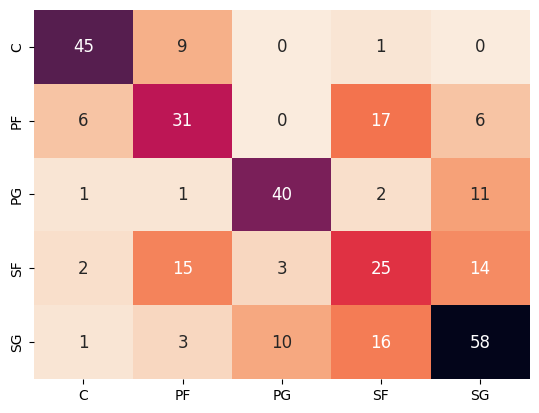

In [21]:
#Sacamos la matriz de confusión para comparar ambas épocas
cm_labels = np.unique(y)
predictions = svm_model.predict(x_test_scaled)
cm_array = confusion_matrix(y_test, predictions)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}, cmap='rocket_r', cbar=False);
plt.savefig('outputs/confusion_actual.jpg')

#Predicciones de los jugadores con categorías mixtas
Predicha = pd.Series(svm_model.predict(scaler.fit_transform(outliers.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1))))
Pos = pd.Series(outliers['Pos']).reset_index(drop=True)
Jugador = pd.Series(outliers['Player']).reset_index(drop=True)
Temporada = pd.Series(outliers['Season']).reset_index(drop=True)

df = pd.concat([Jugador, Temporada, Predicha, Pos], axis=1).reset_index(drop=True)
df.columns = ['Jugador', 'Temporada', 'Predicha', 'Posición']
df.head(15)

In [80]:
#Realizamos un grid search para SVM con DOS CATEGORÍAS
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Binario']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#Definimos el grid de búsqueda
params_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.001, 0.01, 0.5, 1, 5, 10, 15, 20, 100],
    'gamma': ['scale', 'auto'],
    'coef0': [-10, -1, 0, 0.1, 0.5, 1, 10, 100]
}

svm_model = GridSearchCV(SVC(), params_grid, cv=10)
svm_model.fit(x_train_scaled, y_train)


#Vemos los parámetros óptimos para el grid search con SVM
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
print('Best Coef0:',svm_model.best_estimator_.coef0,"\n")
print('Prediccion Test: ',svm_model.best_estimator_.score(x_test_scaled, y_test))

Best score for training data: 0.8826098059244127 

Best C: 0.5 

Best Kernel: rbf 

Best Gamma: scale 

Best Coef0: -10 

Prediccion Test:  0.8661417322834646


In [84]:
#Decission Tree para 5 categorías (con Baggins)
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Pos']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

kfold = model_selection.KFold(n_splits=10)
dtc = DecisionTreeClassifier()

model = BaggingClassifier(base_estimator=dtc,
                n_estimators = 100,
                random_state = 101)

bagging = model
print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.6569458631256385
Accuracy Test:  0.5933198380566802


In [83]:
#Decission Tree para 2 categorías (con Bagging)
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Binario']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)


#Definimos el modelo
kfold = model_selection.KFold(n_splits=10)
dtc = DecisionTreeClassifier()

model = BaggingClassifier(base_estimator=dtc,
                n_estimators = 100,
                random_state = 101)

bagging = model
print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.8769024514811031
Accuracy Test:  0.832051282051282


In [85]:
#Decission Tree para 2 categorías
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Binario']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

model = RandomForestClassifier(n_estimators = 100,
                random_state = 101)

print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.8938712972420838
Accuracy Test:  0.8450742240215924


In [86]:
#Random Forest 5 Cat
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Pos']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#Definimos el modelo
model = RandomForestClassifier(n_estimators = 100,
                random_state = 101)

print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.6569586312563841
Accuracy Test:  0.608974358974359


In [87]:
#Ada Boost para 2 categorías
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Binario']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)


#Definimos el modelo
model = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=2),
            n_estimators = 100,
            random_state = 101)

adaboost = model

print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.8453140960163431
Accuracy Test:  0.824021592442645


In [88]:
#Ada Boost para 5 categorías
#Definimos X e y
X = cinco_cat.iloc[::, 7:29].drop(['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
y = cinco_cat['Pos']

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 101)


#Escalamos las variables
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)


#Definimos el modelo
model = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=2),
            n_estimators = 100,
            random_state = 101)

adaboost = model

print("Accuracy Train: ",model_selection.cross_val_score(model, x_train_scaled, y_train, cv=kfold).mean())
print("Accuracy Test: ",model_selection.cross_val_score(model, x_test_scaled, y_test, cv=kfold).mean())

Accuracy Train:  0.5677093973442288
Accuracy Test:  0.5328609986504723


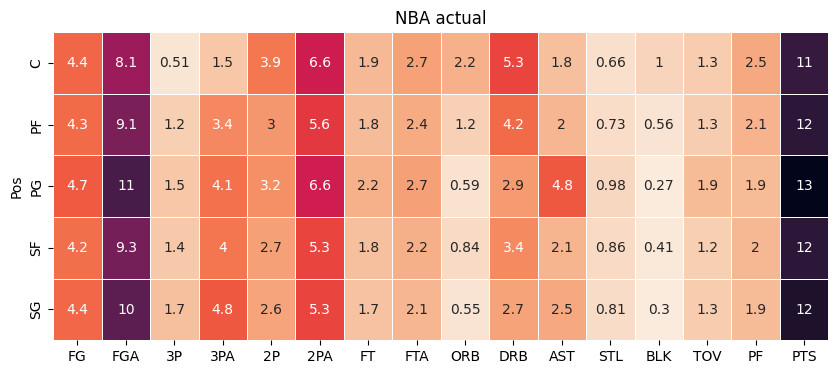

In [10]:
estat = cinco_cat.drop(['Age', 'Tm', 'MP','Player', 'G', 'GS', 'Season', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
plot = estat.groupby('Pos').mean()
nuevo = plot.copy().max()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('NBA actual')
diagrama = sns.heatmap(plot, annot=True, linewidths=.5, ax=ax, cmap = 'rocket_r', cbar=False)
diagrama.figure.savefig("outputs/media_5_cat_actual.png")

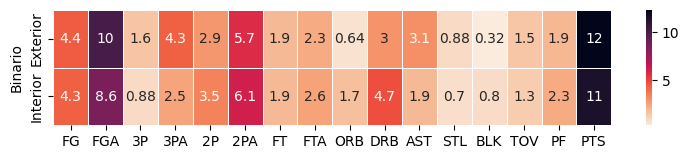

In [4]:
estat = cinco_cat.drop(['Age', 'Tm', 'MP','Player', 'G', 'GS', 'Season', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB'], axis=1)
plot = estat.groupby('Binario').mean()
nuevo = plot.copy().max()

fig, ax = plt.subplots(figsize=(9,1.5))
diagrama = sns.heatmap(plot, annot=True, linewidths=.5, ax=ax, cmap = 'rocket_r')
diagrama.figure.savefig("outputs/media_2_cat_2000.png")